# CNN-Challenge-A: particle image classifier

This notebook is an introduction to one of workshop challenges, a particle image classification. Four type of particles (electron, photon, muon, and proton) are simulated in liquid argon medium and the 2D projections of their 3D energy deposition patterns ("trajectories") are recorded. The challenge is to develop a classifier algorithm that identify which of four types is present in an image.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import torch
torch.multiprocessing.set_start_method('spawn')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import numpy as np
SEED=12345
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

## Data files

* Here's the data file location: `/sdf/group/slacml-school/kmi2020/image_classification`
* A data file with 400,000 images for training: `train.h5`
  * ... which include 100,000 images per particle type
* A data file with 100,000 images for testing: `test.h5`
  * ... which include 25,000 images per particle type

These files are `HDF5` files and can be opened using `h5py`. 


In [2]:
import h5py as h5
datapath='/sdf/group/slacml-school/kmi2020/image_classification/train.h5'

# Open a file in 'r'ead mode.
f=h5.File(datapath,mode='r',swmr=True) 

# List items in the file
for key in f.keys():
    print('dataset',key,'... type',f[key].dtype,'... shape',f[key].shape)

dataset image ... type float32 ... shape (400000, 192, 192)
dataset index ... type int32 ... shape (400000,)
dataset mean ... type float64 ... shape (1,)
dataset pdg ... type int32 ... shape (400000,)
dataset std ... type float64 ... shape (1,)


... and let's visualize one image for fun!

PDG code 13


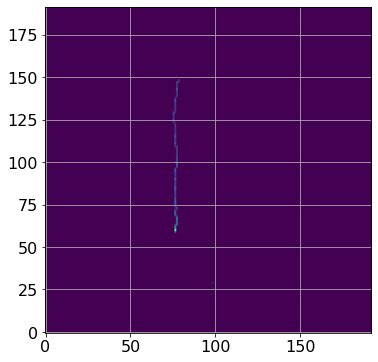

In [3]:
entry = 0

print('PDG code',f['pdg'][entry])
plt.imshow(f['image'][entry],origin='lower')
plt.show()

PDG code 13 means muon (if you are unfamiliar, "PDG code" is a signed integer as a unique identifier of a particle. See [this documentation](https://pdg.lbl.gov/2006/reviews/pdf-files/montecarlo-web.pdf) for more details.)

Let's don't forget to close the file :)

In [4]:
f.close()

## Particle Image `Dataset` and `DataLoader`

We prepared a simple torch `Dataset` implementation for this dataset.

In [5]:
from cnn_challenge_a import ParticleImage2D
train_data = ParticleImage2D(data_files=[datapath])

The dataset is index-accessible and produce a dictionary with four keys
* `data` ... 2D image of a particle (192x192 pixels)
* `pdg` ... PDG code of a particle. Should be [11,13,22,2212] = [electron,muon,photon,proton]
* `label` ... an integer label for classification
* `index` ... an index of the data entry from an input file

Size of dataset 400000
List of keys in a data element dict_keys(['data', 'label', 'pdg', 'index']) 

Again 0-th image! PDG code 13 ... label 1 



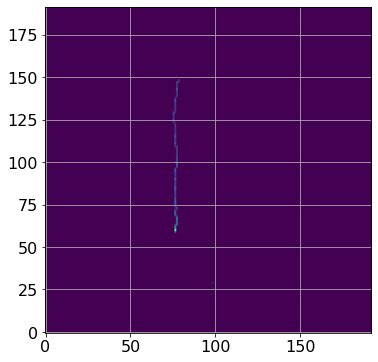

In [6]:
print('Size of dataset',len(train_data))

# Access the 0-th instance
data = train_data[0]

# The data instance is a dictionary
print('List of keys in a data element',data.keys(),'\n')

# Visualize the image
print('Again 0-th image! PDG code %d ... label %d \n' % (data['pdg'],data['label']))
plt.imshow(data['data'],origin='lower')
plt.show()

Create a `DataLoader` instance in a usual way except we give a specifically designed collate function to handle a dictionary style data instance.

In [7]:
train_data = ParticleImage2D(data_files = [datapath],
                             start = 0.0, # start of the dataset fraction to use. 0.0 = use from 1st entry
                             end   = 0.5, # end of the dataset fraction to use. 1.0 = use up the last entry
                            )

# We use a specifically designed "collate" function to create a batch data
from cnn_challenge_a import collate
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data,
                          collate_fn  = collate,
                          shuffle     = True,
                          num_workers = 4,
                          batch_size  = 64
                         )


Let's measure the speed of the dataloader

In [8]:
import time
tstart=time.time()
num_iter=100
ctr=num_iter
for batch in train_loader:
    ctr -=100
    if ctr <= 0: break
print((time.time()-tstart)/num_iter,'[s/iteration]')

0.0397300910949707 [s/iteration]


## Challenge

Here are open-ended challenge project for an image classification.

* Design a machine learning algorithm for performing image classification task. Report the performance (speed, memory, and classification accuracy) you achieved on the test set (remember, use the test set to only benchmark, don't use it for hyper parameter tuning nor training the model!). You might just train very long time, modify the network architecture, or come up with a better training strategy. Let us know what you tried and found!

If you want more guidance, you could try the steps below. But stay open minded and try what you think interesting!

1. Write a python script that trains your model for 70,000 steps using 90% of training sample. Store the network weights every 2500 steps. 

2. Use 10% of training sample as a validation set. Quantify the performance (loss and accuracy) on the stored weights (at every 2500 steps) by running the network inference on the full validation set. You can do this after training is over, or while you are training the network.

3. Look for features in mistakes made by the network. When is it hard for the network to identify a particle? Can you engineer variables to guide this search (e.g. number of pixel count per image v.s. softmax score, average pixel value, etc.)?

4. Play with the network architecture. For instance, if you designed a CNN, could you implement a residual connection? How does that affect the speed and performance of your network?

5. Can we speed-up the network (training time and/or inference time)? What's the trade-off with its performance on the task (i.e. accuracy)? 